# 정확도

정확도(Accuracy) = 예측 결과가 동일한 데이터 건수 / 전체 예측 데이터 건수

정확도는 직관적으로 모델 예측 성능을 나타내는 평가 지표이다.  
하지만 이진 분류의 경우 데이터의 구성에 따라 ML 모델의 성능을 왜곡할 수 있기 때문에 정확도 수치 하나만 가지고 성능을 평가하지 않는다.

예제) 정확도 지표가 어떻게 ML 모델의 성능을 왜곡하는지?

단지 성별 조건 하나만을 가지고 결정하는 별거 아닌 알고리즘도 높은 정확도를 나타내는 상황이 발생한다.

In [1]:
# Null 처리 함수
def fillna(df):
    df['Age'].fillna(df['Age'].mean(), inplace=True)
    df['Cabin'].fillna('N', inplace=True)
    df['Embarked'].fillna('N', inplace=True)
    df['Fare'].fillna(0, inplace=True)
    return df

# 머신러닝 알고리즘에 불필요한 속성 제거
def drop_features(df):
    df.drop(['PassengerId', 'Name', 'Ticket'], axis=1, inplace=True)
    return df

# 레이블 인코딩 수행
def format_features(df):
    from sklearn.preprocessing import LabelEncoder
    df['Cabin'] = df['Cabin'].str[:1]
    features = ['Cabin', 'Sex', 'Embarked']
    for feature in features:
        le = LabelEncoder()
        le = le.fit(df[feature])
        df[feature] = le.transform(df[feature])
    return df

# 위에서 설정한 데이터 전처리 함수 호출
def transform_features(df):
    df = fillna(df)
    df = drop_features(df)
    df = format_features(df)
    return df

In [2]:
from sklearn.base import BaseEstimator

class MyDummyClassifier(BaseEstimator):
    # fit( ) 메서드는 아무것도 학습하지 않음.
    def fit(self, X, y=None):
        pass
    
    # predict( ) 메서드는 단순히 Sex 피처가 1이면 0, 그렇지 않으면 1로 예측함.
    def predict(self, X):
        pred = np.zeros((X.shape[0], 1))
        for i in range(X.shape[0]):
            if X['Sex'].iloc[i] == 1:
                pred[i] = 0
            else:
                pred[i] = 1
        
        return pred

In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# 원본 데이터를 재로딩, 가공, 학습 데이터/테스트 데이터 분할
titanic_df = pd.read_csv('C:\\Users\\jjku0\\OneDrive\\data\\titanic\\train.csv')
y_titanic_df = titanic_df['Survived']
X_titanic_df = titanic_df.drop('Survived', axis=1)
X_titanic_df = transform_features(X_titanic_df)
X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df, test_size=0.2, random_state=0)

# 위에서 생성한 Dummy Classifier를 이용해 학습/예측/평가 수행
myclf = MyDummyClassifier()
myclf.fit(X_train, y_train)

mypredictions = myclf.predict(X_test)
print('Dummy Classifier의 정확도는: {0:.4f}'.format(accuracy_score(y_test, mypredictions)))

Dummy Classifier의 정확도는: 0.7877


특히 정확도는 불균형한(imalanced) 레이블 값 분포에서 ML 모델의 성능을 판단할 경우, 적합한 평가 지표가 아니다.

In [4]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd

class MyFakeClassifier(BaseEstimator):
    def fit(self, X, y):
        pass
    
    # 입력값으로 들어오는 X 데이터 세트의 크기만큼 모두 0 값으로 만들어서 반환
    def predict(self, X):
        return np.zeros((len(X),1), dtype=bool)
    
# 사이킷런의 내장 데이터 세트인 load_digits() 를 이용해 MNIST 데이터 로딩
digits = load_digits()

# digits 번호가 7번이면 True 이고 이를 astype(int)로 1로 변환, 7번이 아니면 False 이고 0으로 변환.
y = (digits.target == 7).astype(int)
X_train, X_test, y_train, y_test = train_test_split(digits.data, y, random_state=11)

불균형한 데이터로 생성한 y_test 의 데이터 분포도를 확인하고 MyFakeClassifier 를 이용해 예측과 평가를 수행

In [10]:
# 불균형한 레이블 데이터 분포도 확인
print('레이블 테스트 세트 크기 :', y_test.shape)
print('테스트 세트 레이블 0과 1의 분포도')
print(pd.Series(y_test).value_counts())

# Dummy Classifier로 학습/예측/정확도 평가
fakeclf = MyFakeClassifier()
fakeclf.fit(X_train, y_train)
fakepred = fakeclf.predict(X_test)
print('모든 예측을 0 으로 하여도 정확도는:{:.3f}'.format(accuracy_score(y_test, fakepred)))

레이블 테스트 세트 크기 : (450,)
테스트 세트 레이블 0과 1의 분포도
0    405
1     45
dtype: int64
모든 예측을 0 으로 하여도 정확도는:0.900


단지 모든 것을 0 으로만 예측해도 MyFakeClassifier의 정확도가 90% 이다.  
이처럼 정확도 평가 지표는 불균형한 레이블 데이터 세트에서는 성능 수치로 사용돼서는 안된다.  
이러한 한계점을 극복하기 위해 여러 가지 분류 지표와 함께 적용해야 한다.

# 오차 행렬

오차행렬(confusion matrix, 혼동행렬)은 학습된 분류 모델이 예측을 수행하면서 얼마나 헷갈리고(confused) 있는지도 함께 보여주는 지표이다.  
즉, 이진 분류의 예측 오류가 얼마인지와 더불어 어떠한 유형의 예측 오류가 발생하고 있는지를 함께 나타내는 지표이다.

<div>
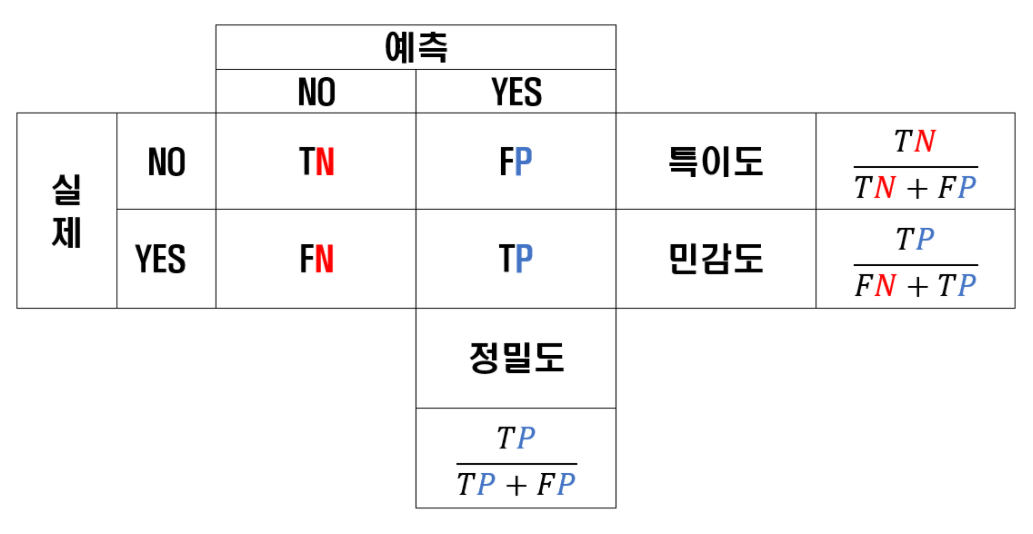
</div>

TN : 예측값을 Negative 값 0으로 예측했고 실제 값 역시 Negative 값 0  
FP : 예측값을 Positive 값 1으로 예측했는데 실제 값은 Negative 값 0  
FN : 예측값을 Negative 값 0으로 예측했는데 실제 값은 Positive 값 1  
TP : 예측값을 Positive 값 1으로 예측했고 실제 값 역시 Positive 값 1

In [11]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, fakepred)  # ndarray 형태

array([[405,   0],
       [ 45,   0]], dtype=int64)

TN : array[0,0] = 405  
FP : array[0,1] = 0  
FN : array[1,0] = 45  
TP : array[1,1] = 0

TN, FP, FN, TP 값을 조합해 Classifier의 성능을 측정할 수 있는 주요 지표인 정확도(Accuracy), 정밀도(Precision), 재현율(Recall) 값을 알 수 있다.  

정확도 = 예측 결과가 동일한 데이터 건수 / 전체 예측 데이터 건수 = (TN + TP)/(TN + FP + FN + TP)

# 정밀도와 재현율

정밀도와 재현율은 Positive 데이터 세트의 예측 성능에 좀 더 초점을 맞춘 평가 지표이다.

정밀도 = TP / (FP + TP)  
재현율 = TP / (FN + TP)

정밀도는 예측을 Positive로 한 대상중에 예측과 실제값이 Positive로 일치한 데이터의 비율  
재현율은 실제 값이 Positive인 대상 중에 예측과 실제 값이 Positive로 일치한 데이터의 비율 (=민감도)  

재현율이 상대적으로 더 중요한 지표인 경우는 실제 Positive 양성 데이터 예측을 Negative로 잘못 판단하게 되면 업무상 큰 영향이 발생하는 경우  
ex) 암 판단 모델, 금융 사기 적발 모델


정밀도가 상대적으로 더 중요 지표인 경우는 실제 Negative 음성인 데이터 예측을 Positive 양성으로 잘못 판단하게 되면 업무상 큰 영향이 발생하는 경우  
보통은 재현율이 정밀도보다 상대적으로 중요한 업무가 많지만, 정밀도가 더 중요한 지표인 경우도 있다.  
ex) 스팸메일 여부를 판단하는 모델

재현율과 정밀도 모두 TP를 높이는 데 동일하게 초점을 맞추지만, 재현율은 FN을 낮추는 데, 정밀도는 FP를 낮추는 데 초점을 맞춘다.  
이 같은 특성 때문에 재현율과 정밀도는 서로 보완적인 지표로 분류의 성능을 평가하는 데 적용된다.  
가장 좋은 성능 평가는 재현율과 정밀도 모두 높은 수치를 얻는 것이다.  
반면에 둘 중 어느 한 평가 지표만 매우 높고, 다른 수치는 매우 낮은 결과를 나타내는 경우는 바람직하지 않다.

In [12]:
# confusion matrix, accuracy, precision, recall 등의 평가를 한꺼번에 호출하는 get_clf_eval() 함수

from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    print('오차 행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}'.format(accuracy, precision, recall))

In [13]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# 원본 데이터를 재로딩, 데이터 가공, 학습 데이터/테스트 데이터 분할
titanic_df = pd.read_csv('C:\\Users\\jjku0\\OneDrive\\data\\titanic\\train.csv')
y_titanic_df = titanic_df['Survived']
X_titanic_df = titanic_df.drop('Survived', axis=1)
X_titanic_df = transform_features(X_titanic_df)

X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df, test_size=0.20, random_state=11)

lr_clf = LogisticRegression()

lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)
get_clf_eval(y_test, pred)

오차 행렬
[[104  14]
 [ 13  48]]
정확도: 0.8492, 정밀도: 0.7742, 재현율: 0.7869


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## 정밀도/재현율 트레이드오프

분류하려는 업무의 특성상 정밀도 또는 재현율이 특별이 강조돼야 할 경우 분류의 결정 임곗값(Threshold)을 조정해 정밀도 또는 재현율의 수치를 높일 수 있다. 하지만 정밀도와 재현율은 상호 보완적인 평가 지표이기 때문에 어느 한쪽을 강제로 높이면 다른 하나의 수치는 떨어지기 쉽다.  
이를 정밀도/재현율의 트레이드오프(Trade-off)라고 부른다.

사이킷런의 분류 알고리즘은 예측 데이터가 특정 레이블(Label, 결정 클래스 값)에 속하는지를 계산하기 위해 먼저 개별 레이블별로 결정 확률을 구한다.  
그리고 예측 확률이 더 큰 레이블값으로 예측하게 된다.  
일반적으로 이진 분류에서는 임계값을 0.5, 즉 50%로 정하고 이 기준 값보다 확률이 크면 Positive, 작으면 Negative 로 결정한다.

In [14]:
pred_proba = lr_clf.predict_proba(X_test)
pred = lr_clf.predict(X_test)
print('pred_proba()결과 Shape : {0}'.format(pred_proba.shape))
print('pred_proba array 에서 앞 3개만 샘플로 추출 \n:', pred_proba[:3])

# 예측 확률 array와 예측 결과값 array를 병합(concatenate)해 예측 확률과 결과값을 한눈에 확인
pred_proba_result = np.concatenate([pred_proba, pred.reshape(-1, 1)], axis=1)
print('두 개의 class 중에서 더 큰 확률을 클래스 값으로 예측 \n', pred_proba_result[:3])

pred_proba()결과 Shape : (179, 2)
pred_proba array 에서 앞 3개만 샘플로 추출 
: [[0.4616653  0.5383347 ]
 [0.87862763 0.12137237]
 [0.87727002 0.12272998]]
두 개의 class 중에서 더 큰 확률을 클래스 값으로 예측 
 [[0.4616653  0.5383347  1.        ]
 [0.87862763 0.12137237 0.        ]
 [0.87727002 0.12272998 0.        ]]


사이킷런은 분류 결정 임계값을 조절해 정밀도와 재현율의 성능 수치를 상호 보완적으로 조정할 수 있다.

In [15]:
# Binarizer 클래스 사용법
from sklearn.preprocessing import Binarizer

X = [[1, -1, 2],
    [2, 0, 0],
    [0, 1.1, 1.2]]

# X의 개별 원소들이 threshold값보다 같거나 작으면 0을, 크면 1을 반환
binarizer = Binarizer(threshold=1.1)
print(binarizer.fit_transform(X))

[[0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]]


In [16]:
# Binarizer 을 이용해 사이킷런 predict()의 의사(pseudo) 코드 만들기
from sklearn.preprocessing import Binarizer

# Binarizer의 threshold 설정값. 분류 결정 임계값
custom_threshold = 0.5

# predict_proba() 반환값의 두 번째 컬럼, 즉 Positive 클래스 컬럼 하나만 추출해 Binarizer를 적용
pred_proba_1 = pred_proba[:, 1].reshape(-1, 1)

binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_1)
custom_predict = binarizer.transform(pred_proba_1)  # 0.5 보다 크면 1, 작으면 0 으로 변환

get_clf_eval(y_test, custom_predict)

오차 행렬
[[104  14]
 [ 13  48]]
정확도: 0.8492, 정밀도: 0.7742, 재현율: 0.7869


In [30]:
# Binarizer의 threshold 설정값을 0.4로 설정. 즉 분류 결정 임계값을 0.5에서 0.4로 낮춰본다.
custom_threshold = 0.4
pred_proba_1 = pred_proba[:, 1].reshape(-1, 1)
binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_1)
custom_predict = binarizer.transform(pred_proba_1)

get_clf_eval(y_test, custom_predict)

오차 행렬
[[99 19]
 [10 51]]
정확도: 0.8380, 정밀도: 0.7286, 재현율: 0.8361


임계값을 낮추니 재현율 값이 올라가고 정밀도가 떨어졌다. 분류 결정 임계값은 Positive 예측값을 결정하는 확률의 기준이 된다.  
확률이 0.5가 아닌 0.4부터 Positive 로 예측을 더 너그럽게 하기 때문에 임계값 값을 낮출수록 True 값이 많아지게 된다.

임계값이 0.5에서 0.4로 낮아지면서 TP가 48에서 51로 늘었고 FN이 13에서 10으로 줄었다.  
그에따라 재현ㅇ율이 0.7869에서 0.8361로 좋아졌지만 FP는 14에서 19로 늘면서 정밀도가 0.7742에서 0.7286으로 많이 나빠졌다.  
그리고 정확도도 0.8492에서 0.8380으로 나빠졌다.

In [31]:
# 임계값을 0.4에서부터 0.6까지 0.05씩 증가시키며 평가 지표를 조사

# 테스트를 수행할 모든 임계값을 리스트 객체로 저장
thresholds = [0.4, 0.45, 0.5, 0.55, 0.6]

def get_eval_by_threshold(y_test, pred_proba_c1, thresholds):
    # thresholds list 객체 내의 값을 차례로 iteration 하면서 Evalution 수행
    for custom_threshold in thresholds:
        binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_c1)
        custom_predict = binarizer.transform(pred_proba_c1)
        print('임계값:', custom_threshold)
        get_clf_eval(y_test, custom_predict)

get_eval_by_threshold(y_test, pred_proba[:, 1].reshape(-1, 1), thresholds)

임계값: 0.4
오차 행렬
[[99 19]
 [10 51]]
정확도: 0.8380, 정밀도: 0.7286, 재현율: 0.8361
임계값: 0.45
오차 행렬
[[103  15]
 [ 12  49]]
정확도: 0.8492, 정밀도: 0.7656, 재현율: 0.8033
임계값: 0.5
오차 행렬
[[104  14]
 [ 13  48]]
정확도: 0.8492, 정밀도: 0.7742, 재현율: 0.7869
임계값: 0.55
오차 행렬
[[109   9]
 [ 15  46]]
정확도: 0.8659, 정밀도: 0.8364, 재현율: 0.7541
임계값: 0.6
오차 행렬
[[112   6]
 [ 16  45]]
정확도: 0.8771, 정밀도: 0.8824, 재현율: 0.7377


In [32]:
from sklearn.metrics import precision_recall_curve  

# 레이블 값이 1일 때의 예측 확률을 추출
pred_proba_class1 = lr_clf.predict_proba(X_test)[:, 1]

# 실제값 데이터 세트와 레이블 값이 1일 때의 예측 확률을 precision_recall_curve 인자로 입력
precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_class1)
print('반환된 분류 결정 임계값 배열의 Shape', thresholds.shape)

# 반환된 임계값 배열 로우가 147건 이므로 샘플로 10건만 추출하되, 임계값을 15 Step으로 추출
thr_index = np.arange(0, thresholds.shape[0], 15)
print('샘플 추출을 위한 임계값 배열의 index 10개:', thr_index)
print('샘플용 10개의 임계값: ', np.round(thresholds[thr_index], 2))

# 15 step 단위로 추출된 임계값에 따른 정밀도와 재현율 값
print('샘플 임계값별 정밀도: ', np.round(precisions[thr_index], 3))
print('샘플 임계값별 재현율: ', np.round(recalls[thr_index], 3))

반환된 분류 결정 임계값 배열의 Shape (143,)
샘플 추출을 위한 임계값 배열의 index 10개: [  0  15  30  45  60  75  90 105 120 135]
샘플용 10개의 임계값:  [0.1  0.12 0.14 0.19 0.28 0.4  0.57 0.67 0.82 0.95]
샘플 임계값별 정밀도:  [0.389 0.44  0.466 0.539 0.647 0.729 0.836 0.949 0.958 1.   ]
샘플 임계값별 재현율:  [1.    0.967 0.902 0.902 0.902 0.836 0.754 0.607 0.377 0.148]


추출된 임계값 샘플 10개에 해당하는 정딜도 값과 재현율 값을 살펴보면 임계값이 증가할수록 정밀도 값은 동시에 높아지나 재현율 값은 낮아짐을 알 수 있다.

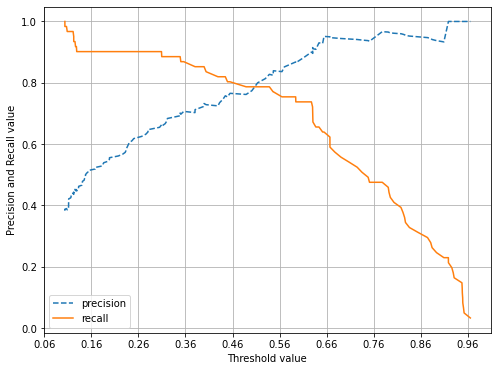

In [66]:
# 정밀도와 재현율의 임계값에 따른 값 변화를 곡선 형태의 그래프로 시각화
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

def precision_recall_curve_plot(y_test, pred_proba_c1):
    # threshold ndarray 와 이 threshold 에 따른 정밀도, 재현율 ndarray 추출
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)
    
    # X축을 threshold 값으로, Y축은 정밀도, 재현율 값으로 각각 Plot 수행. 정밀도는 점선으로 표시
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')  # 정밀도 점선
    plt.plot(thresholds, recalls[0:threshold_boundary], label='recall')  # 재현율 실선
    
    # threshold 값 X 축의 Scale을 0.1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    
    # x축, y축 label 과 legend, 그리고 grid 설정
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    plt.legend(); plt.grid()
    plt.show()
    
precision_recall_curve_plot(y_test, lr_clf.predict_proba(X_test)[:, 1])

임계값이 낮을수록 많은 수의 양성 예측으로 인해 재현율 값이 극도로 높아지고 정밀도 값이 극도로 낮아진다.  
임계값을 계속 증가시킬수록 재현율 값이 낮아지고 정밀도 값이 높아지는 반대의 양상이 된다.  
위의 예제의 로지스틱 회귀 기반의 타이타닉 생존자 예측 모델의 경우 임계값이 약 0.45 지접에서 재현율과 정밀도가 비슷해지는 모습을 보였다.

## 정밀도와 재현율의 맹점

Positive 예측의 임계값을 변경함에 따라 정밀도와 재현율의 수치가 변경된다.  
임계값의 이러한 변경은 업무 환경에 맞게 두 개의 수치를 상호 보완할 수 있는 수준에서 적용돼야 한다.  
그렇지 않고 단순히 하나의 성능 지표 수치를 높이기 위한 수단으로 사용돼서는 안된다.  

### 정밀도가 100% 되는 방법

확실한 기준이 되는 경우만 Positive로 예측하고 나머지는 모두 Negative로 예측한다.  
예를 들어 환자가 80세 이상이고 비만이며 이전에 암 진단을 받았고 암 세포의 크기가 상위 0.1% 이상이면 무조건 Positive, 다른 경우는 Negative 로 예측하는 것이다.  

정밀도 = TP / (TP + FP)  
전체 환자 1000명 중 확실한 Positive 징후만 가진 환자는 단 1명이라고 하면 이 한 명만 Positive로 예측하고 나머지는 모두 Negative 로 예측하더라고 FP는 0, TP는 1이 되므로 정밀도는 1/(1+0) 으로 100% 가 된다.

### 재현율이 100%가 되는 방법

모든 환자를 Positive 로 예측하면 된다. 재현율 = TP / (TP + FN) 이므로 환자 1000명을 다 Positive로 예측하는 것이다.  
이 중 실제 양성인 사람 30명 정도라도 TN이 수치에 포함되지 않고 FN은 아예 0이므로 30/(30+0) 으로 100% 가 된다.

이처럼 정밀도와 재현율 성능 수치도 어느 한쪽만 참고하면 극단적인 수치 조작이 가능하다.  
따라서 정밀도 또는 재현율 중 하나만 스코어가 좋고 다른 하나는 스코어가 나쁜 분류는 성능이 좋지 않은 분류로 간주할 수 있다.  
정밀도와 재현율 수치가 적절하게 조합돼 분류의 종합적인 성능 평가에 사용될 수 있는 평가 지표가 필요하다.